In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string

# Load your dataset
df = pd.read_csv('processed_data.csv')
df['reviews'] = df['reviews'].str.strip()
df = df[(df['reviews'] != "") & (df['reviews'].notna())]
# remove review with less than 2 words 
df = df[df['reviews'].apply(lambda x: len(x.split()) > 2)]
df['sentiment'] = df['sentiment'].map({'negative': 0, 'neutral': 1, 'positive': 2})

df = df[['reviews', 'sentiment']]
# # Calculate the minimum number of rows across sentiment categories
# min_count = df['sentiment'].value_counts().min()

# # Sample from each category
# df_balanced = pd.concat([
#     df[df['sentiment'] == 0].sample(min_count, random_state=42),
#     df[df['sentiment'] == 1].sample(min_count, random_state=42),
#     df[df['sentiment'] == 2].sample(min_count, random_state=42)
# ])

# df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new balanced dataframe
# print(df_balanced.head(20))
# print(df_balanced.shape)
sentiment_counts_balanced = df['sentiment'].value_counts()
print(sentiment_counts_balanced)


sentiment
2    21925
0     6130
1     5623
Name: count, dtype: int64


## Importing Libraries

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalMaxPooling1D, Embedding 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from numpy import asarray
from numpy import zeros
from keras.layers import LSTM

# Splitting data

In [3]:
X = df['reviews']
y = df['sentiment']

In [4]:
from keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

y_train = to_categorical(y_train)
y_test= to_categorical(y_test)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(26942,) (26942, 3)
(6736,) (6736, 3)


# Preparing embedding layer

In [5]:
max_features = 100
word_tokenize = Tokenizer(num_words=max_features, split=' ')
word_tokenize.fit_on_texts(X_train) # creates a dictionary mapping each unique word found in training data - this process is often called "building a vocabulary"
# ^ the frequency of each word is also calculated in this phase, this can be useful for tasks like filtering out infrequent words

X_train = word_tokenize.texts_to_sequences(X_train) # takes text and turns them into a list of numbers - each number represents a specific word in the library
X_test = word_tokenize.texts_to_sequences(X_test)

vocab_size = len(word_tokenize.word_index) + 1
maxlen = max([len(x) for x in X_train])
print(maxlen)

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen) # adds zeros to make sure that all of sequences have the same length
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)




83


### Creating feature matrix using GloVe word embeddings

In [6]:
embeddings_dict = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file: # iterating over every line in the glove_file
  # process each line to extract the word and its vector representation
  records = line.split()
  word = records[0]
  # the embedding word vector is obtained by converting the rest of the list
  # int a NumPy array with float32. This is needed because the the embedding dimension
  # is sorted as a string in the file and we need it to be a floating point number
  # for any mathematical operation we might perform
  vector_dimensions = asarray(records[1:], dtype='float32')
  embeddings_dict[word] = vector_dimensions


glove_file.close()

# Creating embedding matrix 
this will contain 100 dimensional GloVe word embeddings for all words 
in our corpus.
The embedding layer of a neural network is the part of the network that takes input data by 
transforming it into dense vectors of fixed size, often at the very beginning of the model's architecture

In [7]:

# here we initialize the embedding matrix with zeros
# this creates a matrix filled with zeros where the number of rows (vocab_size)
# represents the size of our dataset's vocabulary. and the number of columns 
# represents the dimensionality of teh GloVe vectors we're using
embedding_matrix = zeros((vocab_size, 100))
# here we fill teh embedding matrix with embedding vectors from 'embeddings_dict'
for word, index in word_tokenize.word_index.items():
  embedding_vector = embeddings_dict.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(24382, 100)

# Recurrent Neural Net (LSTM)

In [8]:
from keras.layers import SpatialDropout1D

lstm_model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(SpatialDropout1D(0.2))
lstm_model.add(LSTM(128, dropout=0.4 ))

lstm_model.add(Dense(3, activation='softmax'))

In [9]:

lstm_model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy', metrics=['acc'])
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 83, 100)           2438200   
                                                                 
 spatial_dropout1d (Spatial  (None, 83, 100)           0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2555835 (9.75 MB)
Trainable params: 117635 (459.51 KB)
Non-trainable params: 2438200 (9.30 MB)
_________________________________________________________________


In [10]:
# LSTM untunded 
lstm_untuned = lstm_model.fit(X_train, y_train, epochs=6, batch_size=128, validation_split=0.2, verbose=1)


Epoch 1/6
169/169 [==============================] - 17s 96ms/step - loss: 0.8547 - acc: 0.6597 - val_loss: 0.7961 - val_acc: 0.6524
Epoch 2/6
169/169 [==============================] - 16s 97ms/step - loss: 0.8084 - acc: 0.6709 - val_loss: 0.8087 - val_acc: 0.6903
Epoch 3/6
169/169 [==============================] - 17s 101ms/step - loss: 0.7992 - acc: 0.6708 - val_loss: 0.7776 - val_acc: 0.6701
Epoch 4/6
169/169 [==============================] - 17s 102ms/step - loss: 0.8146 - acc: 0.6516 - val_loss: 0.8057 - val_acc: 0.6510
Epoch 5/6
169/169 [==============================] - 17s 102ms/step - loss: 0.8233 - acc: 0.6566 - val_loss: 0.8159 - val_acc: 0.6584
Epoch 6/6
169/169 [==============================] - 18s 104ms/step - loss: 0.8303 - acc: 0.6654 - val_loss: 0.8244 - val_acc: 0.6779


211/211 [==============================] - 3s 16ms/step
              precision    recall  f1-score   support

    Negative       0.46      0.55      0.50      1215
     Neutral       0.00      0.00      0.00      1194
    Positive       0.73      0.89      0.80      4327

    accuracy                           0.67      6736
   macro avg       0.40      0.48      0.44      6736
weighted avg       0.55      0.67      0.61      6736

  9/211 [>.............................] - ETA: 3s - loss: 0.8495 - acc: 0.6528

/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

211/211 [==============================] - 4s 17ms/step - loss: 0.8306 - acc: 0.6730
lstm model score:  0.8305842876434326


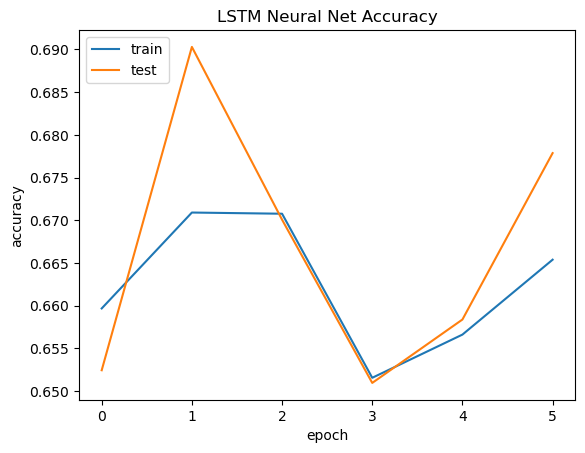

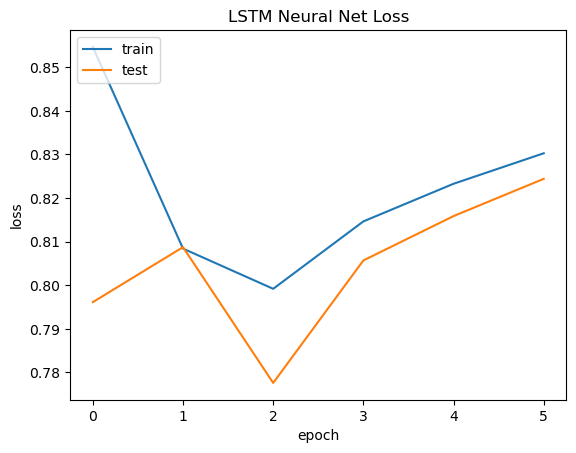

211/211 [==============================] - 3s 15ms/step


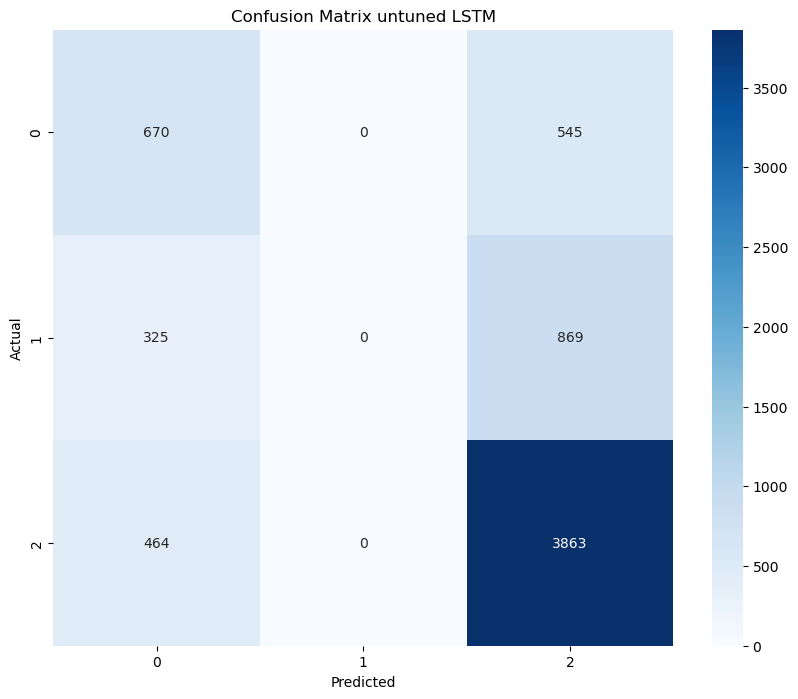

Classification Report tuned LSTM
              precision    recall  f1-score   support

     Class 0       0.46      0.55      0.50      1215
     Class 1       0.00      0.00      0.00      1194
     Class 2       0.73      0.89      0.80      4327

    accuracy                           0.67      6736
   macro avg       0.40      0.48      0.44      6736
weighted avg       0.55      0.67      0.61      6736



/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/aymanadil/anaconda3/envs/sentimentAnalysis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [11]:


# Predict probabilities
untuned_probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
untuned_y_pred = np.argmax(untuned_probabilities, axis=-1)

# Convert y_test from one-hot to class labels if it's one-hot encoded
unTunded_y_true = np.argmax(y_test, axis=-1)

from sklearn.metrics import classification_report

# Generate a classification report
untuned_report = classification_report(unTunded_y_true, untuned_y_pred, target_names=['Negative','Neutral', 'Positive'])

print(untuned_report)

untuned_lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)
print('lstm model score: ', untuned_lstm_score[0])


plt.plot(lstm_untuned.history['acc'])
plt.plot(lstm_untuned.history['val_acc'])

plt.title('LSTM Neural Net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_untuned.history['loss'])
plt.plot(lstm_untuned.history['val_loss'])

plt.title('LSTM Neural Net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


from sklearn.metrics import confusion_matrix 
def untuned_generate_report(model, X_test, y_test, num_classes):
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis=1) 
    # Convert test observations to one hot vectors
    y_true = np.argmax(y_test, axis=1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
    # plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Blues")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix untuned LSTM')
    plt.show()
    
    # Print the classification report
    print('Classification Report tuned LSTM')
    target_names = ['Class {}'.format(i) for i in range(num_classes)]
    print(classification_report(y_true, y_pred_classes, target_names=target_names))

untuned_generate_report(lstm_model, X_test, y_test, 3)


#### Training LSTM model

In [21]:
from sklearn.utils import compute_class_weight

y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_integers), y=y_integers)
class_weight_dict = dict(enumerate(class_weights))

# Now, use this `class_weight_dict` in the `fit` method of your model.
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=12, verbose=1, 
                                    validation_split=0.2, class_weight=class_weight_dict)


Epoch 1/12
169/169 [==============================] - 19s 114ms/step - loss: 0.8535 - acc: 0.6138 - val_loss: 0.7800 - val_acc: 0.6504
Epoch 2/12
169/169 [==============================] - 19s 115ms/step - loss: 0.8555 - acc: 0.6146 - val_loss: 0.7420 - val_acc: 0.6721
Epoch 3/12
169/169 [==============================] - 19s 114ms/step - loss: 0.8495 - acc: 0.6210 - val_loss: 0.7706 - val_acc: 0.6471
Epoch 4/12
169/169 [==============================] - 19s 115ms/step - loss: 0.8463 - acc: 0.6169 - val_loss: 0.8340 - val_acc: 0.6092
Epoch 5/12
169/169 [==============================] - 20s 119ms/step - loss: 0.8441 - acc: 0.6153 - val_loss: 0.7946 - val_acc: 0.6317
Epoch 6/12
169/169 [==============================] - 20s 121ms/step - loss: 0.8426 - acc: 0.6209 - val_loss: 0.9248 - val_acc: 0.5049
Epoch 7/12
169/169 [==============================] - 21s 123ms/step - loss: 0.8410 - acc: 0.6144 - val_loss: 0.8347 - val_acc: 0.5934
Epoch 8/12
169/169 [==============================] - 2

In [22]:

# Predict probabilities
probabilities = lstm_model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(probabilities, axis=-1)

# Convert y_test from one-hot to class labels if it's one-hot encoded
y_true = np.argmax(y_test, axis=-1)

from sklearn.metrics import classification_report

# Generate a classification report
report = classification_report(y_true, y_pred, target_names=['Negative','Neutral', 'Positive'])

print(report)


211/211 [==============================] - 3s 15ms/step
              precision    recall  f1-score   support

    Negative       0.47      0.76      0.58      1215
     Neutral       0.26      0.38      0.31      1194
    Positive       0.89      0.62      0.73      4327

    accuracy                           0.60      6736
   macro avg       0.54      0.59      0.54      6736
weighted avg       0.70      0.60      0.63      6736



In [19]:
lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)
print('lstm model score: ', lstm_score[0])
print('lstm model accuracy: ', lstm_score[1])

211/211 [==============================] - 3s 16ms/step - loss: 0.8764 - acc: 0.5900
lstm model score:  0.876427948474884
lstm model accuracy:  0.5899643898010254


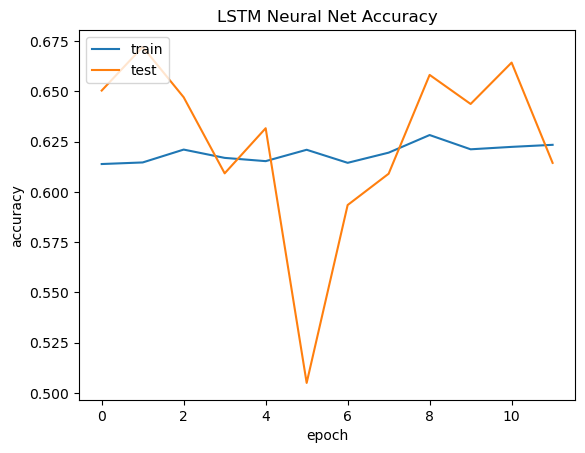

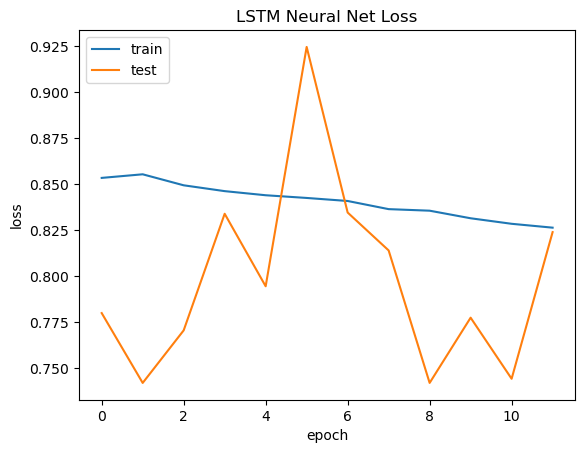

In [23]:

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('LSTM Neural Net Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('LSTM Neural Net Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

211/211 [==============================] - 3s 14ms/step


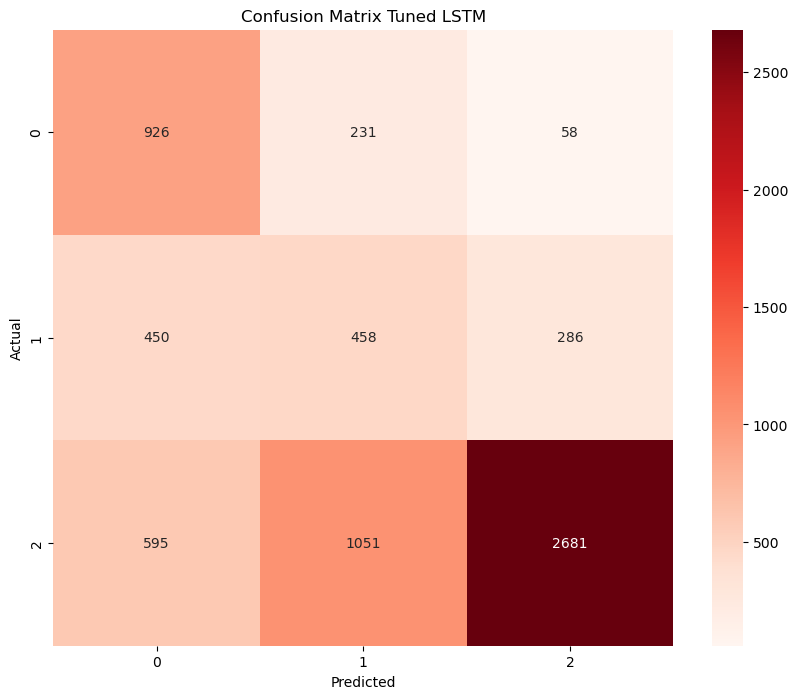

Classification Report tuned LSTM
              precision    recall  f1-score   support

     Class 0       0.47      0.76      0.58      1215
     Class 1       0.26      0.38      0.31      1194
     Class 2       0.89      0.62      0.73      4327

    accuracy                           0.60      6736
   macro avg       0.54      0.59      0.54      6736
weighted avg       0.70      0.60      0.63      6736



In [25]:
from sklearn.metrics import confusion_matrix 
def generate_report(model, X_test, y_test, num_classes):
    # Predict the values from the test dataset
    y_pred = model.predict(X_test)
    # Convert predictions classes to one hot vectors 
    y_pred_classes = np.argmax(y_pred, axis=1) 
    # Convert test observations to one hot vectors
    y_true = np.argmax(y_test, axis=1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
    # plot the confusion matrix
    plt.figure(figsize=(10,8))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap="Reds")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix Tuned LSTM')
    plt.show()
    
    # Print the classification report
    print('Classification Report tuned LSTM')
    target_names = ['Class {}'.format(i) for i in range(num_classes)]
    print(classification_report(y_true, y_pred_classes, target_names=target_names))

generate_report(lstm_model, X_test, y_test, 3)